In [1]:
# libraries used
import boto3
import diff_classifier.aws as aws
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt


from os import listdir, getcwd, chdir
from os.path import isfile, join
import os

from matplotlib import colors as plt_colors

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from kneed import KneeLocator

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture

import shap


In [2]:
workbookDir = getcwd()
print('Current Notebook Dir: ' + workbookDir)
chdir(workbookDir) # Go to current workbook Dir
chdir('..')        # Go up one
print(f'Using current directory for loading data: {getcwd()}')
workbookDir = getcwd()

Current Notebook Dir: /Users/nelsschimek/Documents/Nance Lab/diff_predictor/notebooks
Using current directory for loading data: /Users/nelsschimek/Documents/Nance Lab/diff_predictor


In [3]:
dataset_path = workbookDir + '/raw_data_age/'
filelist = [f for f in listdir(dataset_path) if isfile(join(dataset_path, f))]

In [4]:
filelist

['features_P70_40nm_s3_v3.csv',
 'features_P14_40nm_s3_v3.csv',
 'features_P14_40nm_s3_v2.csv',
 'features_P70_40nm_s3_v2.csv',
 'features_P14_40nm_s1_v5.csv',
 'features_P70_40nm_s1_v5.csv',
 'features_P14_40nm_s3_v1.csv',
 'features_P70_40nm_s1_v4.csv',
 'features_P70_40nm_s3_v1.csv',
 'features_P14_40nm_s1_v4.csv',
 'features_P70_40nm_s3_v5.csv',
 '.DS_Store',
 'features_P14_40nm_s3_v5.csv',
 'features_P14_40nm_s3_v4.csv',
 'features_P70_40nm_s1_v1.csv',
 'features_P70_40nm_s3_v4.csv',
 'features_P14_40nm_s1_v1.csv',
 'features_P14_40nm_s1_v3.csv',
 'features_P70_40nm_s1_v3.csv',
 'features_P70_40nm_s1_v2.csv',
 'features_P14_40nm_s1_v2.csv',
 'features_NT_brain_2_slice_1_vid_4.csv',
 'features_P28_40nm_s2_v5.csv',
 'features_P21_40nm_s2_v1.csv',
 'features_P28_40nm_s2_v4.csv',
 'features_NT_brain_2_slice_1_vid_5.csv',
 'features_P21_40nm_s2_v3.csv',
 'features_P21_40nm_s2_v2.csv',
 'features_P28_40nm_s2_v3.csv',
 'features_NT_brain_2_slice_1_vid_2.csv',
 'features_NT_brain_2_slice_

In [35]:
fstats_tot = None
video_num = 0
for filename in filelist:
    try:
        fstats = pd.read_csv(dataset_path + filename, encoding = "ISO-8859-1", index_col='Unnamed: 0')
        print('{} size: {}'.format(filename, fstats.shape))
        if 'P14' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[14], index=fstats.index)
        elif 'P21' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[21], index=fstats.index)
        elif 'P28' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[28], index=fstats.index)
        elif 'P70' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[70], index=fstats.index)
        elif 'NT_brain_2' in filename:
            fstats['age'] = pd.Series(fstats.shape[0]*[35], index=fstats.index)
        else:
            print('Error, no target')
        fstats['Video Number'] = pd.Series(fstats.shape[0]*[video_num], index=fstats.index)
        if fstats_tot is None:
            fstats_tot = fstats
        else:
            fstats_tot = fstats_tot.append(fstats, ignore_index=True)
        video_num += 1
    except Exception:
            print('Skipped!: {}'.format(filename))

features_P70_40nm_s3_v3.csv size: (2322, 23)
features_P14_40nm_s3_v3.csv size: (323, 91)
features_P14_40nm_s3_v2.csv size: (243, 91)
features_P70_40nm_s3_v2.csv size: (1401, 23)
features_P14_40nm_s1_v5.csv size: (268, 91)
features_P70_40nm_s1_v5.csv size: (17, 23)
features_P14_40nm_s3_v1.csv size: (151, 91)
features_P70_40nm_s1_v4.csv size: (21, 23)
features_P70_40nm_s3_v1.csv size: (2625, 23)
features_P14_40nm_s1_v4.csv size: (140, 91)
features_P70_40nm_s3_v5.csv size: (4162, 23)
Skipped!: .DS_Store
features_P14_40nm_s3_v5.csv size: (389, 91)
features_P14_40nm_s3_v4.csv size: (113, 91)
features_P70_40nm_s1_v1.csv size: (27, 23)
features_P70_40nm_s3_v4.csv size: (2909, 23)
features_P14_40nm_s1_v1.csv size: (793, 91)
features_P14_40nm_s1_v3.csv size: (519, 91)
features_P70_40nm_s1_v3.csv size: (25, 23)
features_P70_40nm_s1_v2.csv size: (12, 23)
features_P14_40nm_s1_v2.csv size: (1356, 91)
features_NT_brain_2_slice_1_vid_4.csv size: (878, 91)
features_P28_40nm_s2_v5.csv size: (372, 91)
f

In [36]:
fstats_tot.head()

,AR,D_fit,Deff1,Deff2,MSD_ratio,Mean_Intensity,Quality,SN_Ratio,Track_ID,X,...,Mean convex_hull,Std convex_hull,Mean convex_hull_norm,Std convex_hull_norm,Mean dist_tot,Std dist_tot,Mean dist_net,Std dist_net,Mean progression,Std progression
0,1.377828,1.466714,0.345123,NaN,0.347071,273.081589,11.597396,1.247060,0.0,456.755044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.844000,34.234700,9.878498,NaN,0.441034,323.044089,13.495678,1.452336,1.0,307.691753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.022024,0.283085,1.399129,NaN,-0.040681,273.148417,9.537690,1.049243,2.0,240.963795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.448351,0.000021,1.842264,NaN,0.003731,313.467054,13.555223,1.444834,3.0,209.178269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15.441644,0.054312,2.066218,0.36868,0.017288,278.409074,13.849725,1.172745,4.0,213.264787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Analysis

In [7]:
fstats_tot.columns

Index(['AR', 'D_fit', 'Deff1', 'Deff2', 'MSD_ratio', 'Mean_Intensity',
       'Quality', 'SN_Ratio', 'Track_ID', 'X', 'Y', 'alpha', 'asymmetry1',
       'asymmetry2', 'asymmetry3', 'boundedness', 'efficiency', 'elongation',
       'fractal_dim', 'frames', 'kurtosis', 'straightness', 'trappedness',
       'Video Number', 'angle_mean', 'angle_mag_mean', 'angle_var',
       'convex_hull', 'convex_hull_norm', 'dist_tot', 'dist_net',
       'progression', 'Mean alpha', 'Std alpha', 'Mean D_fit', 'Std D_fit',
       'Mean kurtosis', 'Std kurtosis', 'Mean asymmetry1', 'Std asymmetry1',
       'Mean asymmetry2', 'Std asymmetry2', 'Mean asymmetry3',
       'Std asymmetry3', 'Mean AR', 'Std AR', 'Mean elongation',
       'Std elongation', 'Mean boundedness', 'Std boundedness',
       'Mean fractal_dim', 'Std fractal_dim', 'Mean trappedness',
       'Std trappedness', 'Mean efficiency', 'Std efficiency',
       'Mean straightness', 'Std straightness', 'Mean MSD_ratio',
       'Std MSD_ratio', 'Me

In [37]:
fstats_tot
features = [
    'alpha', # Fitted anomalous diffusion alpha exponenet
    'D_fit', # Fitted anomalous diffusion coefficient
    'kurtosis', # Kurtosis of track
    'asymmetry1', # Asymmetry of trajecory (0 for circular symmetric, 1 for linear)
    'asymmetry2', # Ratio of the smaller to larger principal radius of gyration
    'asymmetry3', # An asymmetric feature that accnts for non-cylindrically symmetric pt distributions
    'AR', # Aspect ratio of long and short side of trajectory's minimum bounding rectangle
    'elongation', # Est. of amount of extension of trajectory from centroid
    'boundedness', # How much a particle with Deff is restricted by a circular confinement of radius r
    'fractal_dim', # Measure of how complicated a self similar figure is
    'trappedness', # Probability that a particle with Deff is trapped in a region
    'efficiency', # Ratio of squared net displacement to the sum of squared step lengths
    'straightness', # Ratio of net displacement to the sum of squared step lengths
    'MSD_ratio', # MSD ratio of the track
    'frames', # Number of frames the track spans
    'Deff1', # Effective diffusion coefficient at 0.33 s
    'Deff2', # Effective diffusion coefficient at 3.3 s
    'angle_mean', # Mean turning angle which is counterclockwise angle from one frame point to another
    'angle_mag_mean', # Magnitude of the turning angle mean
    'angle_var', # Variance of the turning angle
    'dist_tot', # Total distance of the trajectory
    'dist_net', # Net distance from first point to last point
    'progression', # Ratio of the net distance traveled and the total distance
    'Mean alpha', 
    'Mean D_fit', 
    'Mean kurtosis', 
    'Mean asymmetry1', 
    'Mean asymmetry2',
    'Mean asymmetry3', 
    'Mean AR',
    'Mean elongation', 
    'Mean boundedness',
    'Mean fractal_dim', 
    'Mean trappedness', 
    'Mean efficiency',
    'Mean straightness', 
    'Mean MSD_ratio', 
    'Mean Deff1', 
    'Mean Deff2',
    ]

target = 'age'           # prediction target (y)


linear_features = [
    'Mean Deff1',
    'Mean D_fit',
    'Mean fractal_dim',
    'Mean MSD_ratio',
    'Mean kurtosis',
    'Mean straightness'
    ]
    
ecm = fstats_tot
ecm = ecm[~ecm.isin([np.nan, np.inf, -np.inf]).any(1)]       # Removing nan and inf data points

In [43]:
ecm.head()

,AR,D_fit,Deff1,Deff2,MSD_ratio,Mean_Intensity,Quality,SN_Ratio,Track_ID,X,...,Mean convex_hull,Std convex_hull,Mean convex_hull_norm,Std convex_hull_norm,Mean dist_tot,Std dist_tot,Mean dist_net,Std dist_net,Mean progression,Std progression
0,1.377828,1.466714,0.345123,NaN,0.347071,273.081589,11.597396,1.247060,0.0,456.755044,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.844000,34.234700,9.878498,NaN,0.441034,323.044089,13.495678,1.452336,1.0,307.691753,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.022024,0.283085,1.399129,NaN,-0.040681,273.148417,9.537690,1.049243,2.0,240.963795,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.448351,0.000021,1.842264,NaN,0.003731,313.467054,13.555223,1.444834,3.0,209.178269,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15.441644,0.054312,2.066218,0.36868,0.017288,278.409074,13.849725,1.172745,4.0,213.264787,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
#------------------ADDED-----------------------------
def balance_data(df, target, **kwargs):
    if 'random_state' not in kwargs:
        random_state = 1
    else:
        random_state = kwargs['random_state']
    df_target = []
    bal_df = []
    for name in df[target].unique():
        #if name > 0: # Needed to do remove nan as a name
        df_target.append((name, df[df[target] == name]))
    print(f"Ratio before data balance ({':'.join([str(i[0]) for i in df_target])}) = {':'.join([str(len(i[1])) for i in df_target])}")
    for i in range(len(df_target)):
        #print(len(df_target[i][1]))
        ratio = min([len(i[1]) for i in df_target])/len(df_target[i][1])
        bal_df.append(df_target[i][1].sample(frac=ratio, random_state=random_state))
    print(f"Ratio after balance ({':'.join([str(i[0]) for i in df_target])}) = {':'.join([str(len(i)) for i in bal_df])}")
    return pd.concat(bal_df)
bal_ecm = balance_data(ecm, target, random_state=1)

Ratio before data balance (70:14:35:28:21) = 14498:6416:17169:6194:20665
Ratio after balance (70:14:35:28:21) = 6194:6194:6194:6194:6194


In [46]:
resolution = 128
assert not 2048%resolution and resolution >= 128, "resolution needs to be a factor of 2048 and > 128"
bins = list(range(0, 2048+1, resolution))
bin_labels = [int(i/resolution) for i in bins][:-1]
bal_ecm['binx'] = pd.cut(bal_ecm.X, bins, labels=bin_labels, include_lowest=True)
bal_ecm['biny'] = pd.cut(bal_ecm.Y, bins, labels=bin_labels, include_lowest=True)
bal_ecm['bins'] = (len(bins)-1)*bal_ecm['binx'].astype(np.int32) + bal_ecm['biny'].astype(np.int32)
bal_ecm = bal_ecm[np.isfinite(bal_ecm['bins'])]
bal_ecm['bins'] = bal_ecm['bins'].astype(int)


In [47]:
# Regular split

seed = 1234
np.random.seed(seed)
train_split = 0.5
test_split = 0.5

le = preprocessing.LabelEncoder()
bal_ecm['encoded_target'] = le.fit_transform(bal_ecm[target])

training_bins = np.random.choice(bal_ecm.bins.unique(), int(len(bal_ecm.bins.unique())*train_split), replace=False)

X_train = bal_ecm[bal_ecm.bins.isin(training_bins)]
X_test_val = bal_ecm[~bal_ecm.bins.isin(training_bins)]
X_val, X_test = train_test_split(X_test_val, test_size=test_split, random_state=seed)

y_train = X_train['encoded_target']
y_test = X_test['encoded_target']
y_val = X_val['encoded_target']

In [48]:
bal_ecm.head()

,AR,D_fit,Deff1,Deff2,MSD_ratio,Mean_Intensity,Quality,SN_Ratio,Track_ID,X,...,Mean dist_tot,Std dist_tot,Mean dist_net,Std dist_net,Mean progression,Std progression,binx,biny,bins,encoded_target
35077,2.033185,4.550878,0.555820,NaN,1.273327,218.661439,8.986170,1.205778,48.0,1273.206807,...,NaN,NaN,NaN,NaN,NaN,NaN,9,15,159,4
9000,1.258759,13.151902,12.026700,NaN,-0.013900,302.250342,11.624815,1.362179,1489.0,1487.349658,...,NaN,NaN,NaN,NaN,NaN,NaN,11,9,185,4
14044,1.532306,0.003525,2.253900,NaN,0.023993,307.224935,21.214782,1.228200,1842.0,58.839203,...,NaN,NaN,NaN,NaN,NaN,NaN,0,6,6,4
14213,3.119389,1.273647,5.505599,NaN,-0.039421,297.807364,10.182736,1.331036,2011.0,570.922954,...,NaN,NaN,NaN,NaN,NaN,NaN,4,6,70,4
8593,2.956834,39.493399,5.169901,NaN,0.422108,340.265504,11.871380,1.345308,1082.0,92.957048,...,NaN,NaN,NaN,NaN,NaN,NaN,0,9,9,4


In [53]:
#Check lengths of datasets:
def get_lengths(df, X_train, X_test, X_val=None):
    print(f'Tot before split: {len(df)}')
    print(f'Training: {len(X_train)} ({len(X_train)/len(bal_ecm):.3f}%)')
    print(f'Testing: {len(X_test)} ({len(X_test)/len(bal_ecm):.3f}%)')
    try:
        print(f'Evaluation: {len(X_val)} ({len(X_val)/len(bal_ecm):.3f}%)')
    except:
        pass
get_lengths(bal_ecm, X_train, X_test, X_val)

Tot before split: 30970
Training: 15369 (0.496%)
Testing: 7801 (0.252%)
Evaluation: 7800 (0.252%)


In [55]:
X = X_train[linear_features].dropna()
print(len(X_train[linear_features]))
print(len(X))
print()

ss = StandardScaler()
scaled_features = ss.fit_transform(X.values)
kmean = KMeans(n_clusters=3, init='k-means++').fit(scaled_features)
centroids = kmean.cluster_centers_

print('SSE value: ', kmean.inertia_)
print('Num iterations for convergence: ', kmean.n_iter_)
#spec = SpectralClustering(n_clusters=4).fit(X)

15369
12106

SSE value:  44386.257568399415
Num iterations for convergence:  7


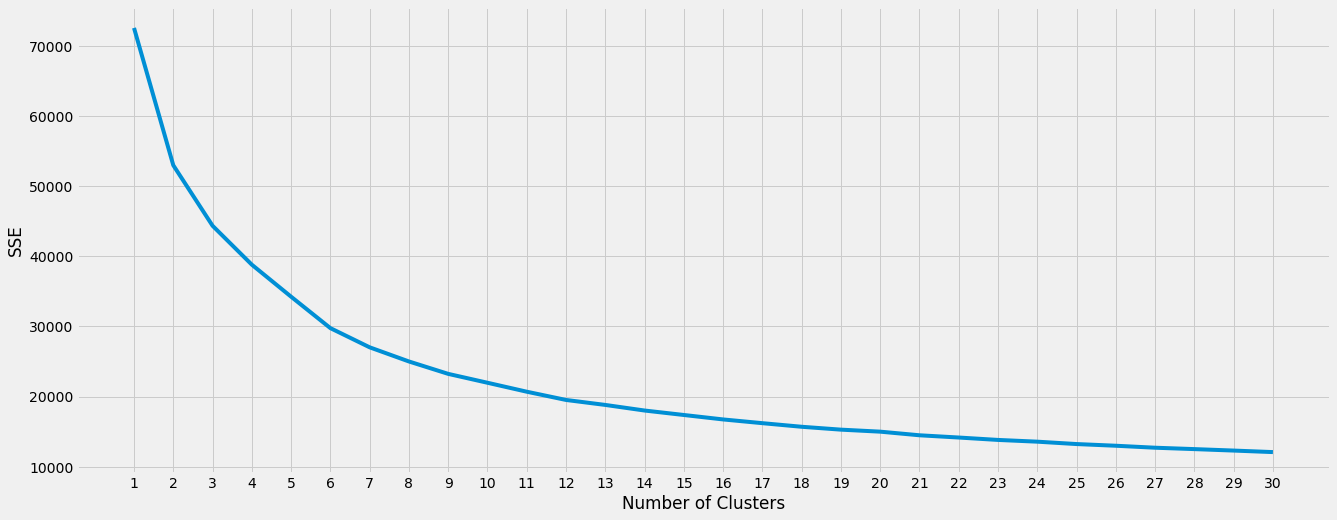

In [56]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 31):
    clusterer = KMeans(n_clusters=k, init='k-means++')
    clusterer.fit(scaled_features)
    sse.append(clusterer.inertia_)


plt.figure(figsize=(20,8))
plt.style.use("fivethirtyeight")
plt.plot(range(1, 31), sse)
plt.xticks(range(1, 31))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [57]:
## Find the elbow point
kl = KneeLocator(
    range(1, 31), sse, curve="convex", direction="decreasing"
)

print("Optimal number of clusters based on elbow method: ", kl.elbow)

Optimal number of clusters based on elbow method:  7


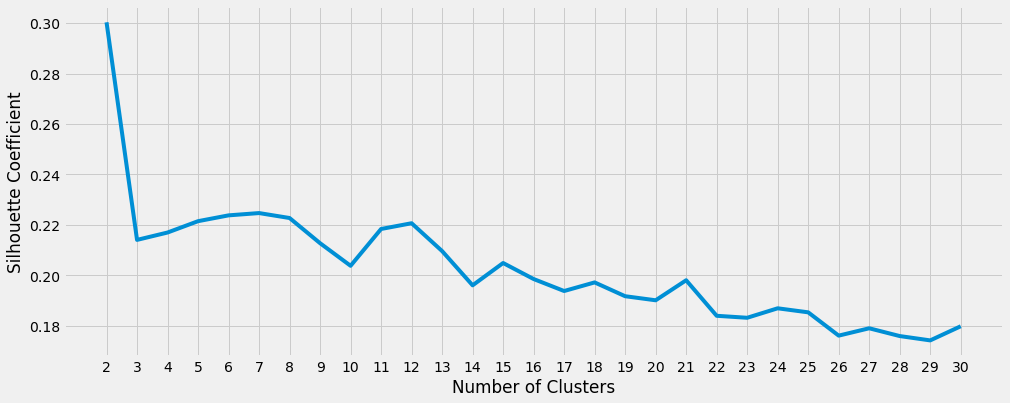

In [58]:
# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 31):
    clusterer = KMeans(n_clusters=k)
    clusterer.fit(scaled_features)
    score = metrics.silhouette_score(scaled_features, clusterer.labels_)
    silhouette_coefficients.append(score)


plt.figure(figsize=(15,6))
plt.style.use("fivethirtyeight")
plt.plot(range(2, 31), silhouette_coefficients)
plt.xticks(range(2, 31))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

For n_clusters = 7 The average silhouette_score is : 0.22443929908895838


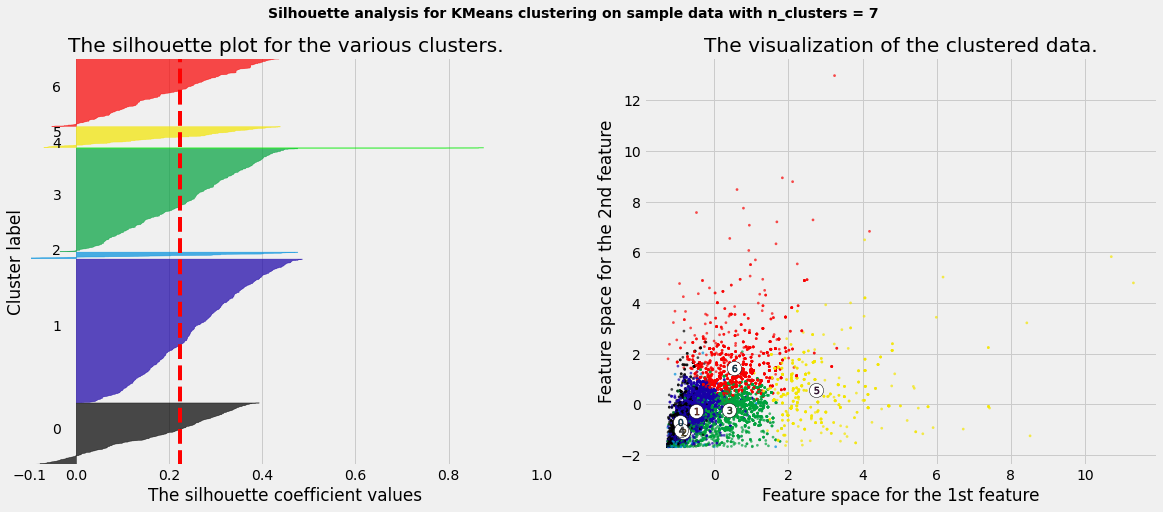

In [63]:
# let's take a look at what silhouette analysis looks like:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = scaled_features
n_clusters = 7
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(scaled_features)
cluster_labels = kmeans.labels_
score = silhouette_score(scaled_features, cluster_labels)


# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(scaled_features) + (n_clusters + 1) * 10])


# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(scaled_features, cluster_labels)
print("For n_clusters =", n_clusters,
    "The average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(scaled_features, cluster_labels)

y_lower = 10
    
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1,0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
           "with n_clusters = %d" % n_clusters),
           fontsize=14, fontweight='bold')

plt.show()

In [23]:
#spec = SpectralClustering(n_clusters=2, n_init=10, n_jobs=-1)
#spec.fit(X)
#spec_pred = spec.fit_predict(X=X_test, affinity='precomputed')

In [167]:
#preds = kmean.predict(X_test[linear_features].dropna())
all_preds = []
for age in [14, 21, 28, 35]:
    filt_X_test = X_test[X_test['age'] == age]
    filt_X_test = filt_X_test[linear_features].dropna()
    preds = kmean.predict(filt_X_test)
    all_preds.append(preds)

In [169]:
for ls in all_preds:
    for i in range(0,4):
        plt.figure(figsize=(8,6))
        ct = (ls == i).sum()
        ct
        print(ct)
    print()

576
365
244
282

911
58
556
52

592
30
782
97

526
7
986
35



<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>